# Модули

In [156]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Добавим стиля

In [157]:
plt.style.use('dark_background')

# Синтетические данные

Генерации данных

In [158]:
def true_fun(x, a=np.pi, b = 0, f=np.sin):
    x = np.atleast_1d(x)[:]
    a = np.atleast_1d(a)
    
    if f is None: f = lambda x:x # line
    x = np.sum([ai*np.power(x, i+1) for i,ai in enumerate(a)],axis=0)

    return f(x+ b)

def noises(shape , noise_power):
    return np.random.randn(*shape) *noise_power

def dataset(a, b, f = None,  N = 250, x_max =1, noise_power = 0, random_x = True,  seed = 42):
    np.random.seed(seed)
    
    if random_x:
        x = np.sort(np.random.rand(N))*x_max    
    else:
        x = np.linspace(0,x_max,N)
    
    y_true = np.array([])
    
    for f_ in np.append([], f):
        y_true=np.append(y_true, true_fun(x, a, b, f_))
    
    y_true = y_true.reshape(-1,N).T
    y = y_true + noises(y_true.shape , noise_power)

    return y, y_true, np.atleast_2d(x).T

In [159]:
def vis_data(y, y_true,x, title):
    fig  = plt.figure(figsize=(15,10))
    plt.scatter(x[:,0], y, edgecolor='b', label="Зашумленные Данные",s=196, alpha = 0.6)
    plt.scatter(x[:,0], y_true,label="Реальные Данные", s=81,c='g', alpha = 0.8)
    plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35)
    plt.legend(fontsize=25)
    plt.title(title, fontsize=25 )
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);
    plt.tight_layout()


Добавление больше шума, увеличено количество точек и x

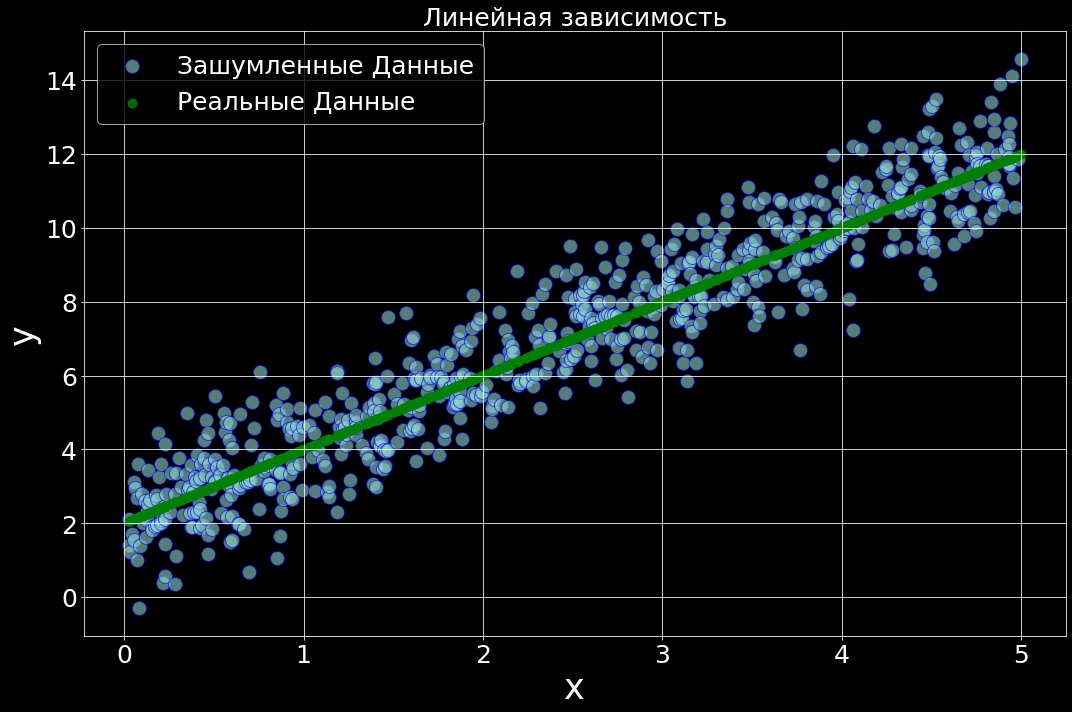

In [160]:
noise_power = 1

y, y_true, x = dataset(a = 2, b = 2,
                       f = None,  N = 700,
                       x_max =5, 
                       noise_power = noise_power,
                       seed = 42)
vis_data(y, y_true,x, 'Линейная зависимость')

Разделение на тренировочную и тестовую выборки

In [161]:
def train_test_split(x,y, train_size=None, test_size=None, random_state=50, shuffle=True,):
    if random_state: np.random.seed(random_state)
    
    size = y.shape[0]
    idxs = np.arange(size)
    if shuffle: np.random.shuffle(idxs)
    
    if test_size and train_size is None:
        if (test_size<= 1):  train_size = 1 - test_size
        else:  train_size = size - test_size
        test_size = None    
        
    if train_size is None or train_size > size: train_size = size
        
    if (train_size<= 1): train_size *= size
        
    if test_size is not None: 
        if test_size<= 1: test_size *= size    
        if test_size>size: test_size = size-train_size
    else: test_size = 0

    x_train, y_train = x[idxs[:int(train_size)]], y[idxs[:int(train_size)]]
    x_val,   y_val   = x[idxs[int(train_size):size - int(test_size)]], y[idxs[int(train_size):size - int(test_size)]]
    
    if test_size > 0:
        x_test, y_test = x[idxs[size - int(test_size):]], y[idxs[size - int(test_size):]]
        return x_train, y_train.squeeze(), x_val, y_val.squeeze(), x_test, y_test.squeeze() 
    return x_train, y_train.squeeze(), x_val, y_val.squeeze()


x_train, y_train, x_val, y_val, x_test, y_test = train_test_split(x, y, train_size = 0.5, test_size=0.3, )    
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape,  x_test.shape, y_test.shape )

    
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(350, 1) (350,) (140, 1) (140,) (210, 1) (210,)
(489, 1) (489,) (211, 1) (211,)


In [162]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(489, 1) (489,) (211, 1) (211,)


Класс линейной регрессии

In [163]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000,
                 n_batches    = None,
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        self.n_batches = n_batches
        
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return np.dot(X, self.weights)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat.squeeze()
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))
    
    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)

        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            self.batch_size = y.size
            
        if self.n_batches is None:
            self.n_batches = y.size//self.batch_size
            
        for i in range(self.epochs): 
            loss = 0
            for cnt,(x_batch, y_batch) in enumerate(self.load_batch(X,y)): 

                yhat         = self.forward(x_batch)
                self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
                self.weights = self.update() 
                loss += self.loss(yhat,  y_batch)
                
                if cnt>= self.n_batches:
                    break
            self.cost[i] = loss/self.n_batches
        
        self.bias = self.weights[0]
    #---------------------------------
    def load_batch(self,X,y):
        idxs = np.arange(y.size)
        np.random.shuffle(idxs)

        for i_batch in range(0,y.size,self.batch_size):
            idx_batch = idxs[i_batch:i_batch+self.batch_size]
            x_batch   = np.take(X, idx_batch,axis=0)
            x_batch   = self.add_bias(x_batch)
            y_batch   = np.take(y, idx_batch)
            yield  x_batch, y_batch
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))
    
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Реализуем линейную регрессию

In [164]:
myreg = LinearRegression(learning_rate=0.1,
                        epochs=10,batch_size=10,
                        n_batches=None)
myreg.fit(x_train, y_train)

Функцию потерь

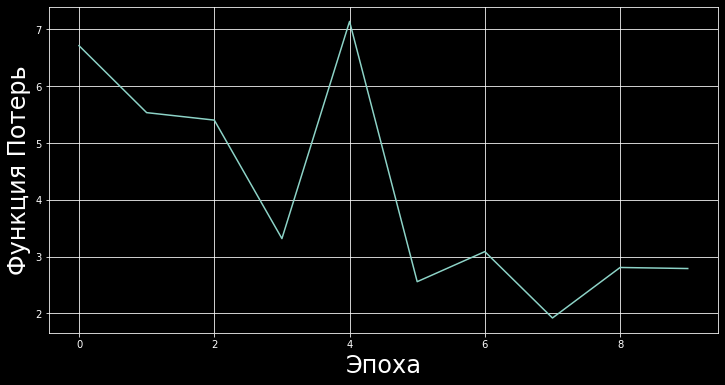

In [165]:
myreg.plot_cost()

In [166]:
def plot_model_class(x_train, y_train, x_test, x, y, model):
    plt.plot(x_train[:,0], model.predict(x_train),
            '.', label='Предсказание на x_train',
            markersize = 15)
    plt.plot(x_test[:,0], model.predict(x_test),
            'o', label='Предсказание на x_test',
            markersize = 15, alpha =0.8)
    plt.plot(x_train[:,0], y_train, '.',
            label="Тренировочные данные", linewidth=2,c='r')
    plt.plot(x[:,0], y, '--',
            label="Истинные Значения", linewidth=4,c='g')
    plt.legend(fontsize=20); plt.grid()
    plt.xlabel('x',fontsize=35)
    plt.ylabel('y',fontsize=35);
    plt.xticks(FontSize = 25)
    plt.yticks(FontSize = 25);

Просматриваем график

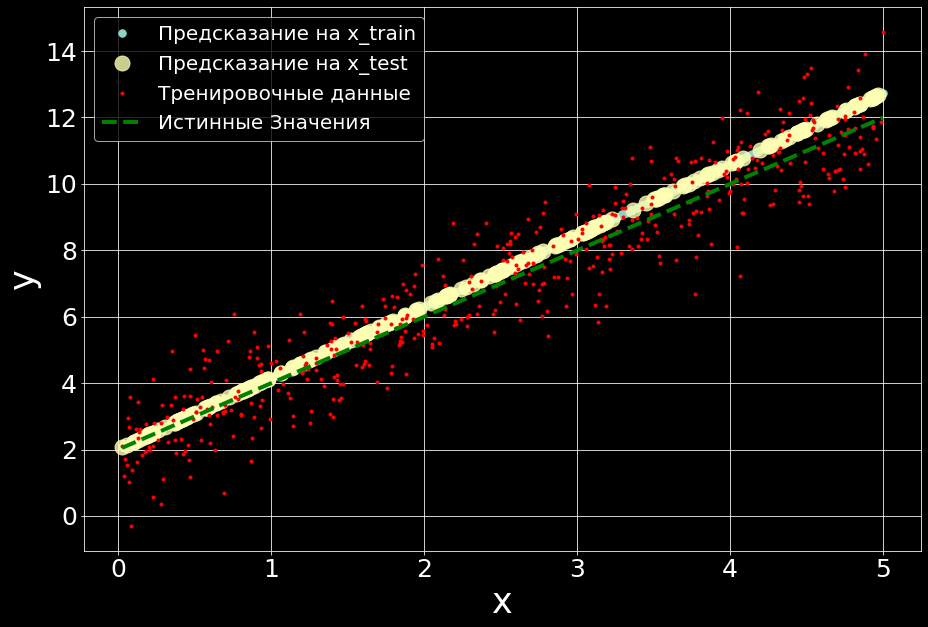

In [167]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, myreg)

**Вывод**

Можно сделать вывод, что на данных с большим шумом значение потерь уменьшается медленнее и неравномернее чем с маленьким шумом, но, по итогу, модель всё равно приходит к точным предсказаниям.

# Полиномиальная зависимость

Изменённый набор данных: больше шума, меньше х максимальный, что заставляет график изгибаться по-другому

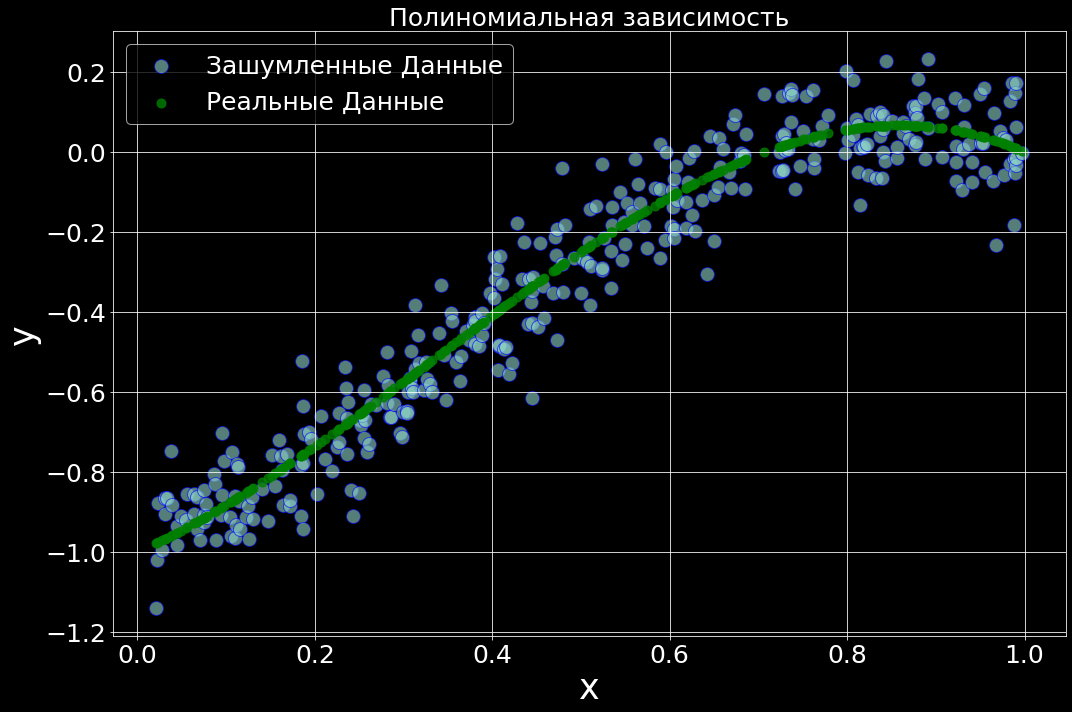

In [168]:
noise_power = 0.09

y, y_true, x = dataset(a = [1,2,-2], b = -1,
                       f = None,  N = 350,
                       x_max =1, 
                       noise_power = noise_power,
                       seed = 45)
vis_data(y, y_true,x, 'Полиномиальная зависимость')

Делаем полином с пятой степенью

In [169]:
def to_polynom(x, order = 1, add_bias = False):
    order_range = range( 0 if add_bias else 1, order+1,1)
    x = np.atleast_1d(x)[:]    
    out = np.array([])
    for i in order_range:
        out = np.append(out, np.power(x,i))
    return out.reshape(-1, x.size).T
  

In [170]:
x_ = to_polynom(x, order = 5) 
x_train, y_train,  x_test, y_test = train_test_split(x_, y,  test_size=0.3, )

Реализуем линейную регрессию

In [171]:
regr_poly = LinearRegression(learning_rate=0.1,
                        epochs=100,batch_size=10,
                        n_batches=None)

In [172]:
regr_poly.fit(x_train, y_train)

Делаем график

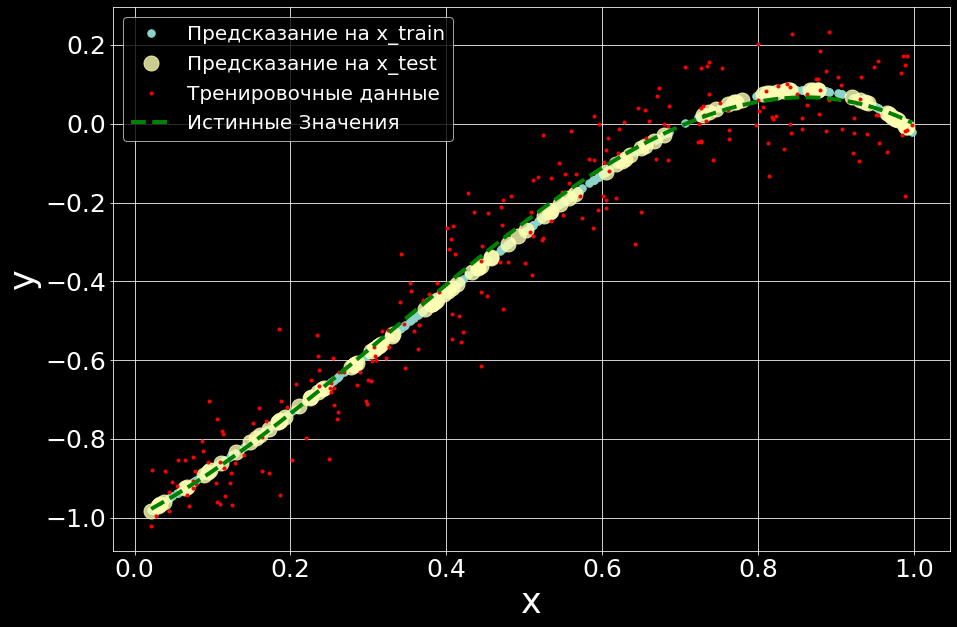

In [173]:
fig  = plt.figure(figsize=(15,10))

plot_model_class(x_train, y_train, x_test, x, y_true, regr_poly)


Решил попробовать увеличить размер выборки

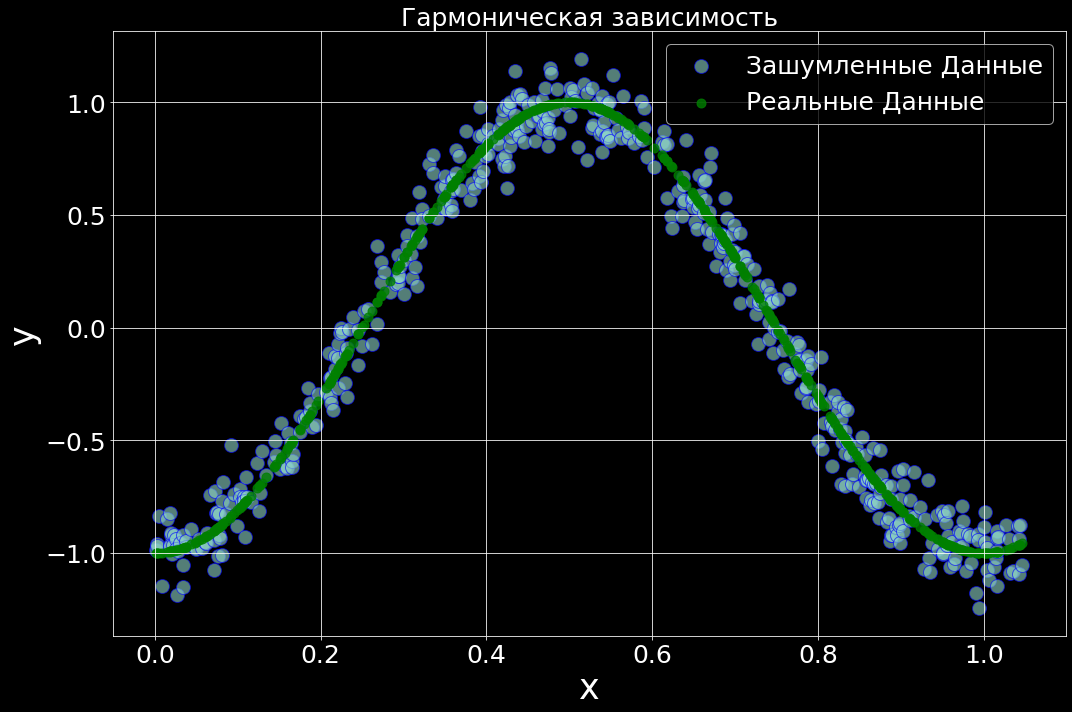

In [174]:
y, y_true, x = dataset(a = 2*np.pi,
                       b = np.pi, f = np.cos,  
                       N = 500, x_max =np.pi/3, 
                       noise_power = 0.1, seed = 52)
vis_data(y, y_true,x, 'Гармоническая зависимость')

In [175]:
x_train, y_train,  x_test, y_test = train_test_split(x, y,  test_size=0.3, )    
print(x_train.shape, y_train.shape,  x_test.shape, y_test.shape )

(350, 1) (350,) (150, 1) (150,)


Train Score = -0.09


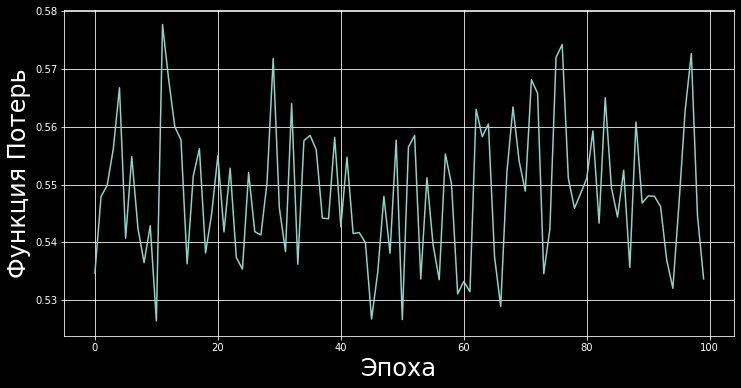

In [176]:
regr_harm = LinearRegression(learning_rate=0.25,
                        epochs=100,batch_size=10,
                        n_batches=None)
regr_harm.fit(x_train, y_train)

print(f'Train Score = {regr_harm.score(x_train, y_train):.2f}')
regr_harm.plot_cost()

In [177]:
w, b = regr_harm.get_w_and_b()
print(w,b)

[-0.22270078] 0.3137499320727055


Создаём полином десятой степени

In [178]:
order  = 10

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9
346,0.687687,0.472913,0.325216,0.223647,0.153799,0.105765,7.273353e-02,5.001788e-02,3.439664e-02,2.365411e-02
347,0.184447,0.034021,0.006275,0.001157,0.000213,0.000039,7.262710e-06,1.339584e-06,2.470820e-07,4.557350e-08
348,0.115326,0.013300,0.001534,0.000177,0.000020,0.000002,2.713315e-07,3.129168e-08,3.608755e-09,4.161847e-10
349,0.143825,0.020686,0.002975,0.000428,0.000062,0.000009,1.273026e-06,1.830928e-07,2.633329e-08,3.787381e-09


Проводим линейную регрессию

Test Score = 0.94, Train Score = 0.94


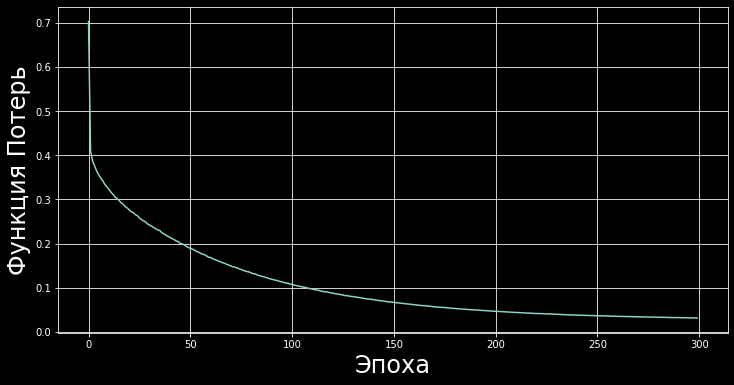

In [179]:
regr_harm_poly = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly.fit(x_train_, y_train)
print(f'Test Score = {regr_harm_poly.score(x_test_, y_test):.2f}, Train Score = {regr_harm_poly.score(x_train_, y_train):.2f}')
regr_harm_poly.plot_cost()

In [180]:
w, b = regr_harm_poly.get_w_and_b()
print(w,b)

[ 4.97783609 -0.41089488 -2.32225093 -2.31029269 -2.30542563 -1.45141743
  0.03200747  0.64293956  1.04204497  2.06794154] -1.0841504357318243


Добавляем скейлеры

In [181]:
class MinMaxScaler:
    def __init__(self):
        self.min = 0
        self.max = 0
    def fit(self,X):
        self.min = X.min(axis = 0)
        self.max = X.max(axis = 0)
        return self
    def transform(self,X):
        return (X- self.min)/(self.max-self.min)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [182]:
class StandardScaler:
    def __init__(self):
        self.mean = 0
        self.std = 1
    def fit(self,X):
        self.mean = X.mean(axis = 0)
        self.std = X.std(axis = 0)
        return self
    def transform(self,X):
        return (X- self.mean)/(self.std)
    def fit_transform(self,X):
        return self.fit(X).transform(X)

In [183]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

In [184]:
pd.DataFrame(x_test_scaled).tail(4)

,0,1,2,3,4,5,6,7,8,9
146,-0.965619,-0.987116,-0.886699,-0.783545,-0.698894,-0.631441,-0.576911,-0.531876,-0.493988,-0.461657
147,1.011562,1.020861,0.936737,0.815538,0.682095,0.549678,0.425647,0.313748,0.215451,0.130825
148,1.548566,1.941696,2.226217,2.444523,2.612185,2.737677,2.827465,2.887132,2.921573,2.935027
149,-0.436919,-0.663151,-0.721892,-0.706732,-0.664838,-0.616809,-0.570756,-0.529324,-0.492941,-0.461230


Повторно проводим линейную регрессию

Test Score = 0.95, Train Score = 0.96


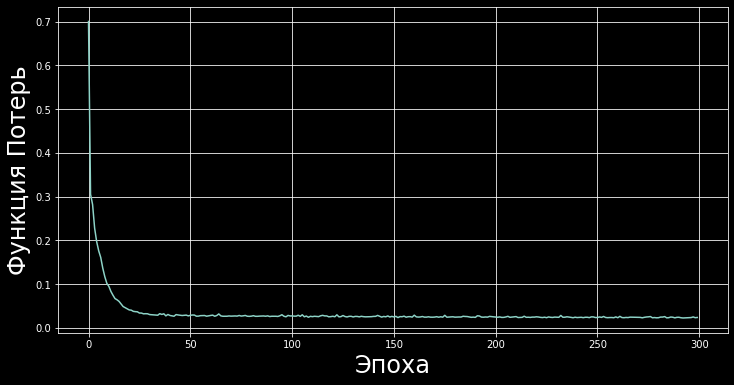

In [185]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

Смотрим веса

In [186]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.92133307 -0.45323988 -1.13606396 -0.76271683 -0.83384497 -0.33145456
  0.60215462  0.51687557  0.11486404  0.26912033] -0.044089933206105214


In [187]:
np.sum(np.abs(w))

6.941667833711531

Рисуем график

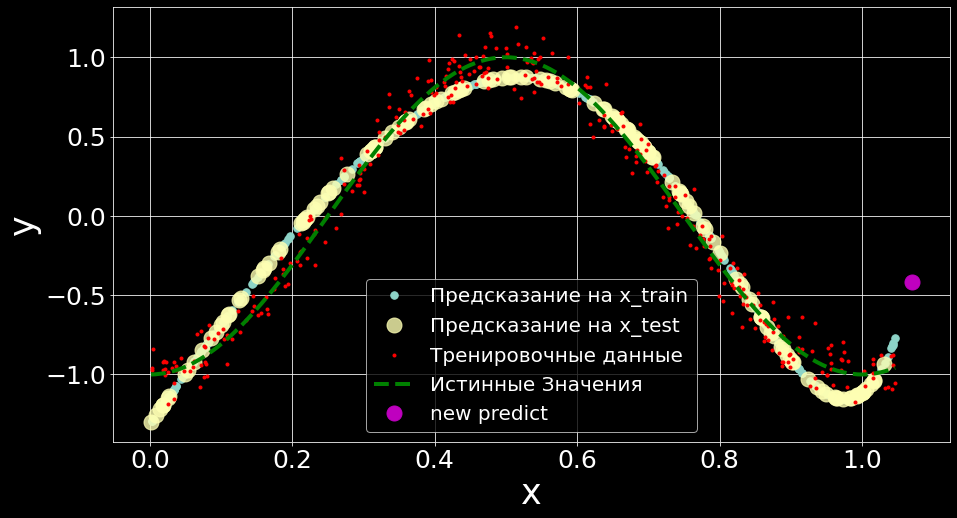

In [188]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'new predict',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);



**Вывод**

Увеличить размер выборки не помогло

А что будет, если увеличить разрядность полинома до 15 и повторить всё то же самое?

In [189]:
order  = 15

x_train_ = to_polynom(x_train, order=order)
x_test_  = to_polynom(x_test,  order=order)


pd.DataFrame(x_train_).tail(4)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
346,0.687687,0.472913,0.325216,0.223647,0.153799,0.105765,7.273353e-02,5.001788e-02,3.439664e-02,2.365411e-02,1.626662e-02,1.118634e-02,7.692697e-03,5.290166e-03,3.637977e-03
347,0.184447,0.034021,0.006275,0.001157,0.000213,0.000039,7.262710e-06,1.339584e-06,2.470820e-07,4.557350e-08,8.405889e-09,1.550440e-09,2.859737e-10,5.274695e-11,9.729009e-12
348,0.115326,0.013300,0.001534,0.000177,0.000020,0.000002,2.713315e-07,3.129168e-08,3.608755e-09,4.161847e-10,4.799706e-11,5.535327e-12,6.383691e-13,7.362079e-14,8.490418e-15
349,0.143825,0.020686,0.002975,0.000428,0.000062,0.000009,1.273026e-06,1.830928e-07,2.633329e-08,3.787381e-09,5.447195e-10,7.834419e-11,1.126784e-11,1.620595e-12,2.330819e-13


In [190]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_)
x_test_scaled = scaler.transform(x_test_)

Test Score = 0.96, Train Score = 0.97


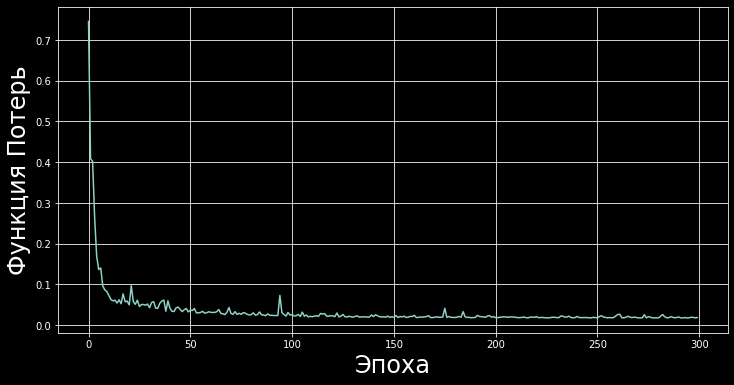

In [191]:
regr_harm_poly_scale = LinearRegression(learning_rate=0.05,
                        epochs=300,batch_size=25,
                        n_batches=None
                        )

regr_harm_poly_scale.fit(x_train_scaled, y_train)
print(f'Test Score = {regr_harm_poly_scale.score(x_test_scaled, y_test):.2f}, Train Score = {regr_harm_poly_scale.score(x_train_scaled, y_train):.2f}')
regr_harm_poly_scale.plot_cost()

Смотрим веса

In [192]:
w, b = regr_harm_poly_scale.get_w_and_b()
print(w,b)

[ 1.91505984 -0.29377038 -1.130519   -0.9441241  -0.99427638 -0.49402086
  0.40914434  0.51079843  0.37096361  0.69365431  0.39795068  0.28543459
  0.29949806 -0.46622618 -0.65433496] -0.04269545876629923


In [193]:
np.sum(np.abs(w))

9.85977570946347

Рисуем график

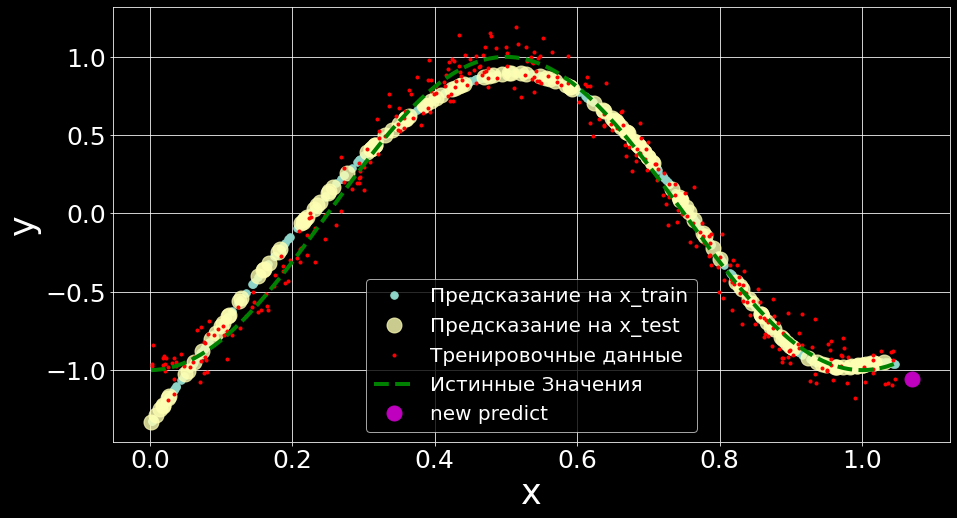

In [194]:
plt.figure(figsize=(15,8))

plt.plot(x_train_[:,0], regr_harm_poly_scale.predict(x_train_scaled),
        '.', label='Предсказание на x_train',
        markersize = 15)
plt.plot(x_test[:,0], regr_harm_poly_scale.predict(x_test_scaled),
        'o', label='Предсказание на x_test',
        markersize = 15, alpha =0.8)
plt.plot(x_train_[:,0], y_train, '.',
        label="Тренировочные данные", linewidth=2,c='r')
plt.plot(x[:,0], y_true, '--',
        label="Истинные Значения", linewidth=4,c='g')

plt.plot([1.07], 
         regr_harm_poly_scale.predict(scaler.transform(to_polynom([1.07], order=order))), 
         'mo',  label = 'new predict',
        markersize = 15 )
plt.legend(fontsize=20); plt.grid()
plt.xlabel('x',fontsize=35)
plt.ylabel('y',fontsize=35);
plt.xticks(FontSize = 25)
plt.yticks(FontSize = 25);



# Реальные данные (Cars Moldova)

Импорт данных

In [195]:
from google.colab import files
import seaborn as sns; 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

In [196]:
uploaded = files.upload()

In [197]:
df = pd.read_csv('/content/cars_moldova_cat_num.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro),Age,km_year,Mileage,Rare
0,71,535,2011,4,195000.0,1800.0,2,1,7750.0,11,17727.272727,High,Not rare
1,58,359,2014,11,135000.0,1500.0,0,0,8550.0,8,16875.000000,High,Not rare
2,58,419,2012,11,110000.0,1500.0,0,0,6550.0,10,11000.000000,Middle,Not rare
3,53,137,2006,11,200000.0,1600.0,3,0,4100.0,16,12500.000000,Middle,Not rare
4,47,725,2000,5,300000.0,2200.0,0,0,3490.0,22,13636.363636,Middle,Not rare
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32199,74,511,2016,10,88000.0,1800.0,4,1,11500.0,6,14666.666667,High,Not rare
32200,40,324,2002,3,225000.0,1800.0,3,0,4400.0,20,11250.000000,Middle,Not rare
32201,16,433,2015,11,89000.0,1500.0,0,0,7000.0,7,12714.285714,Middle,Not rare
32202,46,76,2006,1,370000.0,2000.0,0,0,4000.0,16,23125.000000,High,Not rare


In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32204 entries, 0 to 32203
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Make                  32204 non-null  int64  
 1   Model                 32204 non-null  int64  
 2   Year                  32204 non-null  int64  
 3   Style                 32204 non-null  int64  
 4   Distance              32204 non-null  float64
 5   Engine_capacity(cm3)  32204 non-null  float64
 6   Fuel_type             32204 non-null  int64  
 7   Transmission          32204 non-null  int64  
 8   Price(euro)           32204 non-null  float64
 9   Age                   32204 non-null  int64  
 10  km_year               32204 non-null  float64
 11  Mileage               32204 non-null  object 
 12  Rare                  32204 non-null  object 
dtypes: float64(4), int64(7), object(2)
memory usage: 3.2+ MB


In [199]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission', 'Mileage']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)', 'km_year']

Линейная регрессия только по числовым столбцам

Разделение данных на тренировочный и тестовые

In [200]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32204 entries, 0 to 32203
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32204 non-null  int64  
 1   Distance              32204 non-null  float64
 2   Engine_capacity(cm3)  32204 non-null  float64
 3   Price(euro)           32204 non-null  float64
 4   km_year               32204 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 1.2 MB


,0,1,2,3
22537,0.68,0.184726,0.229167,0.216071
22538,0.88,0.119704,0.333333,0.341534
22539,0.84,0.154927,0.270833,0.343594
22540,0.86,0.186727,0.375000,0.466428
22541,0.58,0.299765,0.479167,0.271263


Класс линейной регрессии

In [201]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15, mfc='none' ); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(FontSize = 25)

    plt.yticks(FontSize = 25);

In [202]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

Запускаем линейную регрессию с данными из таблицы

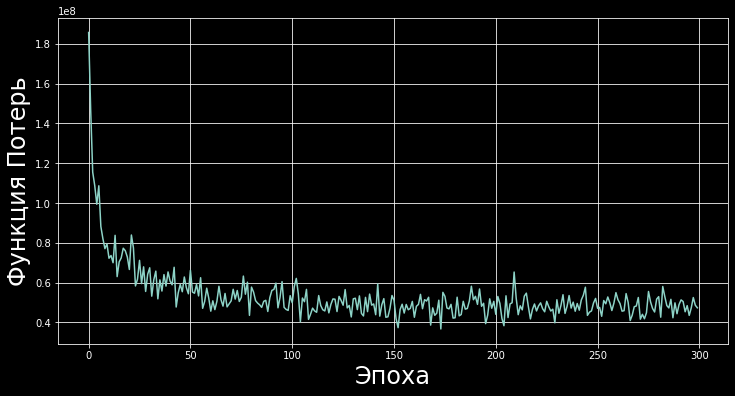

train R2: 0.4848; test R2: 0.4851


In [203]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Смотрим веса

In [204]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 45 );

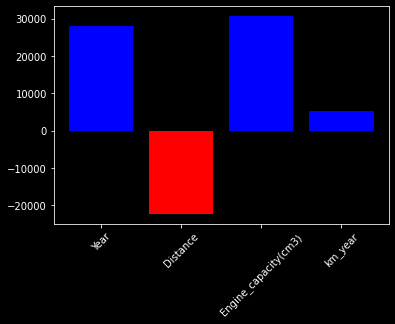

In [205]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [206]:
np.sum(np.abs(w))

86247.69843139128

Регуляризация

In [207]:
class RidgeRegression(LinearRegression):
    def __init__(self, 
                 learning_rate = 0.5,
                 l2_penalty = 0.001,
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        
        super().__init__(learning_rate = learning_rate,
                         epochs = epochs, 
                         weights = weights, 
                         bias    = bias, 
                         batch_size   = batch_size, 
                         random_state = random_state)
        self.l2_penalty = l2_penalty
    #---------------------------------
    def loss(self,yhat, y):   
        l2_term = (self.l2_penalty/2)*np.sum(np.square(self.weights[1:]))
        return np.square(yhat - y).mean() + l2_term
                  
    
    #---------------------------------
    def update(self):    
        l2_term = self.l2_penalty*np.sum(self.weights[1:])
        return self.weights - self.lr*(self.grad + l2_term) 


Запускаем регрессию с регуляризацией

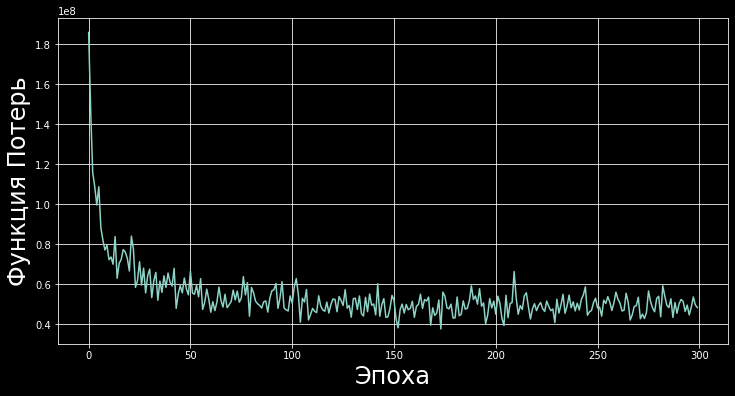

train R2: 0.4844; test R2: 0.4846


In [208]:
regr = RidgeRegression(learning_rate=0.5,epochs=300,batch_size=3000, l2_penalty = 0.001)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Смотрим веса

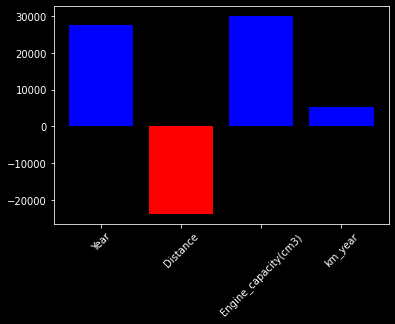

In [209]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [210]:
np.sum(np.abs(w))

86518.78514970766

Ничего не изменилось

# Разные типы предварительной обработки

Нормализуем данные

In [211]:
DF_norm  = df_num.copy()
Xmin = df_num[num_columns].min()
Xmax = df_num[num_columns].max()

DF_norm[num_columns] = (df_num[num_columns]- Xmin)/( Xmax - Xmin)
DF_norm.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,0.80,0.194729,0.333333,0.075651,0.353252
1,0.86,0.134709,0.270833,0.083667,0.336172
2,0.82,0.109701,0.270833,0.063627,0.218437
3,0.70,0.199731,0.291667,0.039078,0.248497
4,0.58,0.299765,0.416667,0.032966,0.271270


Разделяем тестовую и тренировочную выборку

In [212]:
X,y = DF_norm.drop(columns = ['Price(euro)']).values,DF_norm['Price(euro)'].values

features_names = DF_norm.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2,3
22537,0.68,0.184726,0.229167,0.216071
22538,0.88,0.119704,0.333333,0.341534
22539,0.84,0.154927,0.270833,0.343594
22540,0.86,0.186727,0.375000,0.466428
22541,0.58,0.299765,0.479167,0.271263


Проводим линейную регрессию

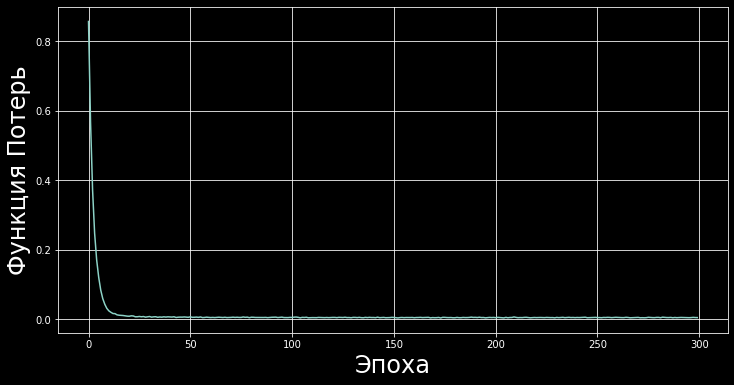

train R2: 0.4723; test R2: 0.4748


In [213]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Смотрим веса

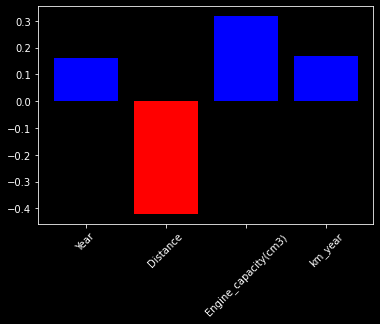

In [214]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [215]:
np.sum(np.abs(w))

1.0668835685758205

Нормализация данных улучшила результат.

Стандартизация

In [216]:
DF_scaled = df_num.copy()
M = df_num[num_columns].mean()
STD = df_num[num_columns].std()
DF_scaled[num_columns] = (df_num[num_columns]-M)/STD

DF_scaled.head()

,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,0.377569,0.128130,-0.112354,-0.178118,0.377244
1,0.795059,-0.492060,-0.604252,-0.093889,0.261000
2,0.516733,-0.750473,-0.604252,-0.304461,-0.540310
3,-0.318247,0.179813,-0.440286,-0.562412,-0.335720
4,-1.153226,1.213463,0.543510,-0.626637,-0.180728


Тренировочная и тестовая выборки

In [217]:
X,y = DF_scaled.drop(columns = ['Price(euro)']).values,DF_scaled['Price(euro)'].values

features_names = DF_scaled.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2,3
22537,0.68,0.184726,0.229167,0.216071
22538,0.88,0.119704,0.333333,0.341534
22539,0.84,0.154927,0.270833,0.343594
22540,0.86,0.186727,0.375000,0.466428
22541,0.58,0.299765,0.479167,0.271263


Регрессия

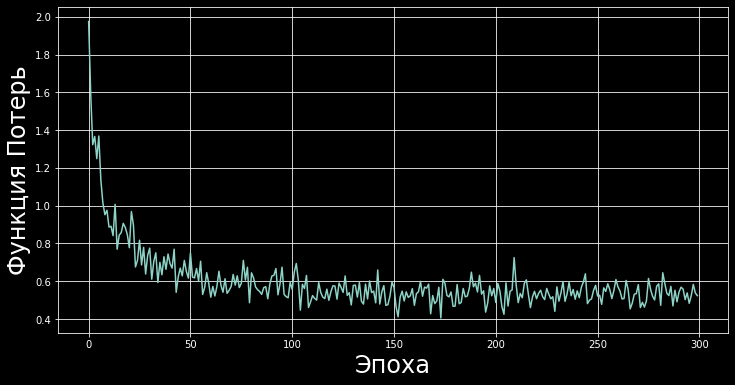

train R2: 0.4844; test R2: 0.4853


In [218]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Веса

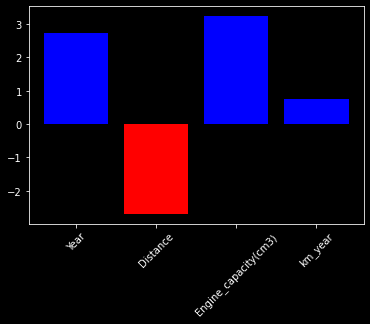

In [219]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)

In [220]:
np.sum(np.abs(w))

9.41714602376344

Со стандартизацией функция потерь падает точно также неровно, как и без неё, но зато уменьшаются веса.

# Добавление категориальных признаков

One-hot кодирование

In [221]:
df_dum = df.copy()
df_dum = pd.get_dummies(df_dum[cat_columns])
df_dum

,Make,Model,Style,Fuel_type,Transmission,Mileage_High,Mileage_Low,Mileage_Middle
0,71,535,4,2,1,1,0,0
1,58,359,11,0,0,1,0,0
2,58,419,11,0,0,0,0,1
3,53,137,11,3,0,0,0,1
4,47,725,5,0,0,0,0,1
...,...,...,...,...,...,...,...,...
32199,74,511,10,4,1,1,0,0
32200,40,324,3,3,0,0,0,1
32201,16,433,11,0,0,0,0,1
32202,46,76,1,0,0,1,0,0


Добавляю числовые признаки нормализованные

In [222]:
df_dum['Year'] = DF_norm['Year']
df_dum['Distance'] = DF_norm['Distance']
df_dum['Engine_capacity(cm3)'] = DF_norm['Engine_capacity(cm3)']
df_dum['Price(euro)'] = DF_norm['Price(euro)']
df_dum['km_year'] = DF_norm['km_year']
df_dum

,Make,Model,Style,Fuel_type,Transmission,Mileage_High,Mileage_Low,Mileage_Middle,Year,Distance,Engine_capacity(cm3),Price(euro),km_year
0,71,535,4,2,1,1,0,0,0.80,0.194729,0.333333,0.075651,0.353252
1,58,359,11,0,0,1,0,0,0.86,0.134709,0.270833,0.083667,0.336172
2,58,419,11,0,0,0,0,1,0.82,0.109701,0.270833,0.063627,0.218437
3,53,137,11,3,0,0,0,1,0.70,0.199731,0.291667,0.039078,0.248497
4,47,725,5,0,0,0,0,1,0.58,0.299765,0.416667,0.032966,0.271270
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32199,74,511,10,4,1,1,0,0,0.90,0.087693,0.333333,0.113226,0.291917
32200,40,324,3,3,0,0,0,1,0.62,0.224740,0.333333,0.042084,0.223447
32201,16,433,11,0,0,0,0,1,0.88,0.088694,0.270833,0.068136,0.252791
32202,46,76,1,0,0,1,0,0,0.70,0.369788,0.375000,0.038076,0.461423


In [223]:
X,y = df_dum.drop(columns = ['Price(euro)']).values,df_dum['Price(euro)'].values

features_names = df_dum.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

,0,1,2,3,4,5,6,7,8,9,10,11
22537,0.649351,0.304910,0.363636,0.8,0.0,0.0,0.0,1.0,0.68,0.184726,0.229167,0.216071
22538,0.610390,0.217054,0.909091,0.8,1.0,1.0,0.0,0.0,0.88,0.119704,0.333333,0.341534
22539,0.207792,0.351421,0.272727,0.0,0.0,1.0,0.0,0.0,0.84,0.154927,0.270833,0.343594
22540,0.064935,0.138243,0.909091,0.0,1.0,1.0,0.0,0.0,0.86,0.186727,0.375000,0.466428
22541,0.415584,0.445736,0.818182,0.0,0.0,0.0,0.0,1.0,0.58,0.299765,0.479167,0.271263


Линейная регрессия - уменьшено количество эпох и learning rate

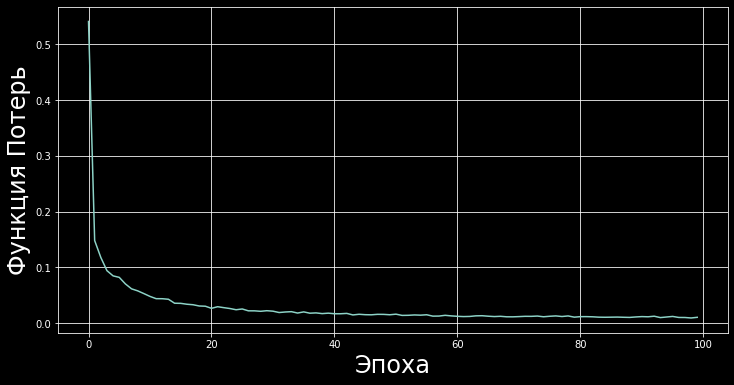

train R2: -0.0993; test R2: -0.0894


In [224]:
regr = LinearRegression(learning_rate=0.1,epochs=100,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))

Добавление категориальных данных помогло сделать результаты предсказания более точными.

# Анализ весов

Самый точный график весов из модели с нормализированными данными.

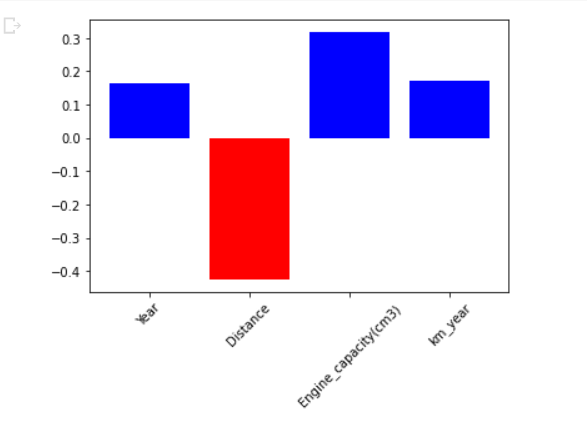

Судя по графику, цена действительно больше на автомобили с маленьким пробегом.

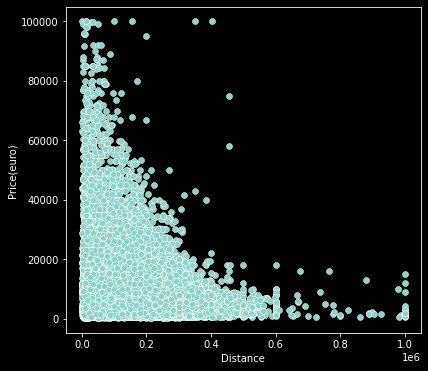

In [225]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.scatterplot(x='Distance',y='Price(euro)',data=df,ax=ax)

#Вывод

Можно сделать вывод, что объём двигателя наиболее значим для модели, а год производства и удельный пробег примерно равны по важности